In [1]:
from awloss import AWLoss

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

%autoreload 2
import sys
sys.path.append('../') 
from networks import *
from utils import *
from landscape import *
from datasets import *
from train_utils import *

import json
import pathlib
import matplotlib.pyplot as plt

/home/dp4018/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

# Set training static parameters and hyperparameters
nepochs=100
latent_size = 128                            
learning_rate=1e-3
batch_size=512                                        
device=set_device("cuda", 0)
valid_ratio = 0.2
logf = int(nepochs//5) + 1


Cuda installed! Running on GPU0 NVIDIA GeForce RTX 2080 Ti!


## Datasets and Dataloaders

Training images: 162080 	 Validation Images: 40519


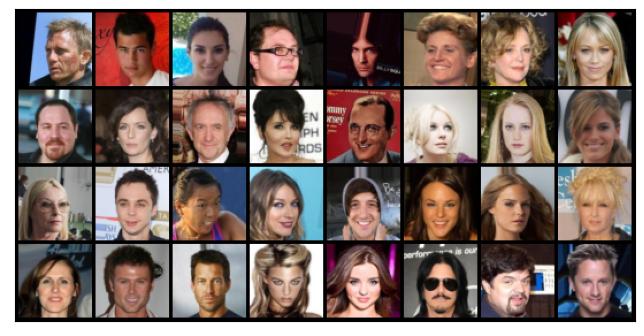

torch.Size([32, 3, 64, 64]) 0.0 1.0


In [3]:
# Datasets and dataloaders
img_dim = 64
ds = ImageFolder(root="/home/dp4018/scripts/AWLoss/examples/data/celeba/",
                               transform=Compose([
                               Resize(img_dim),
                               CenterCrop(img_dim),
                               ToTensor()]))

# Train / validation split
idxs = np.arange(0, len(ds), 1)
i = int(len(ds)*valid_ratio)
np.random.seed(42)
np.random.shuffle(idxs)
train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
# train_idxs, valid_idxs = [0], [0]
trainds, validds = Subset(ds, train_idxs), Subset(ds, valid_idxs)
print("Training images: {} \t Validation Images: {}".format(len(trainds), len(validds)))

# Dataloaders
train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(validds, batch_size=batch_size, shuffle=False, num_workers=4)

# Visualise batch
sample_batch = next(iter(train_loader))[0][:32]
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(make_grid(sample_batch, pad_value=0, padding=3).numpy(),(1,2,0)))
plt.xticks([]); plt.yticks([])
plt.show()

print(sample_batch.shape, sample_batch.min().item(), sample_batch.max().item())

## Autoencoder (CNN)

In [4]:
def model_instance():
    model = ResizeConvAE(latent_size=latent_size, 
                        n_channels=sample_batch.shape[1],
                        pre_latent_size=int(img_dim/2/2)).to(device)
    model = nn.DataParallel(model, device_ids=[0, 1])
    return model

model_sample = model_instance()
_ = summary(model=model_sample, input_data=sample_batch[0].shape, verbose=1, depth=3, 
            col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─ResizeConvAE: 1-1                      []                        []                        --
├─ResizeConvAE: 1                        []                        []                        --
|    └─Sequential: 2-1                   []                        []                        --
|    └─Sequential: 2                     []                        []                        --
|    |    └─Block: 3-1                   []                        []                        480
├─ResizeConvAE: 1-2                      [-1, 3, 64, 64]           [-1, 3, 64, 64]           --
├─ResizeConvAE: 1                        []                        []                        --
|    └─Sequential: 2-2                   [-1, 3, 64, 64]           [-1, 128]                 --
|    └─Sequential: 2                     []                        []                        --
|    |    └─Block: 3-2            

## Training AWLoss 3D

In [5]:
def laplacian3D(mesh):
    alpha, beta = -0.3, 1.5
    xx, yy, zz = mesh[:,:,:,0], mesh[:,:,:,1], mesh[:,:,:,2]
    x = torch.sqrt(xx**2 + yy**2 + zz**2) 
    T = 1 - torch.exp(-torch.abs(x) ** alpha) ** beta
    T = scale2range(T, [0.2, 1.])
    return T

In [8]:
awloss = AWLoss(filter_dim=3,  std=1e-1, epsilon=250., filter_scale=2, 
                reduction="sum", method="fft", store_filters="unorm", penalty_function=laplacian3D)     
                
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, nepochs, eta_min=learning_rate/10)
summary_app = {"latent_size":latent_size,
                "aw_filter_dim": awloss.filter_dim,
                "aw_epsilon":  awloss.epsilon,
                "aw_std": awloss.std,
                "filter_scale": awloss.filter_scale,
                "penalty": awloss.penalty_function.__name__}

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



Training started ...


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())



 {'epoch': 0, 'train_loss': 63.46360397338867, 'valid_loss': 52.79043197631836}
Filters range: [-0.11 , 1.00]


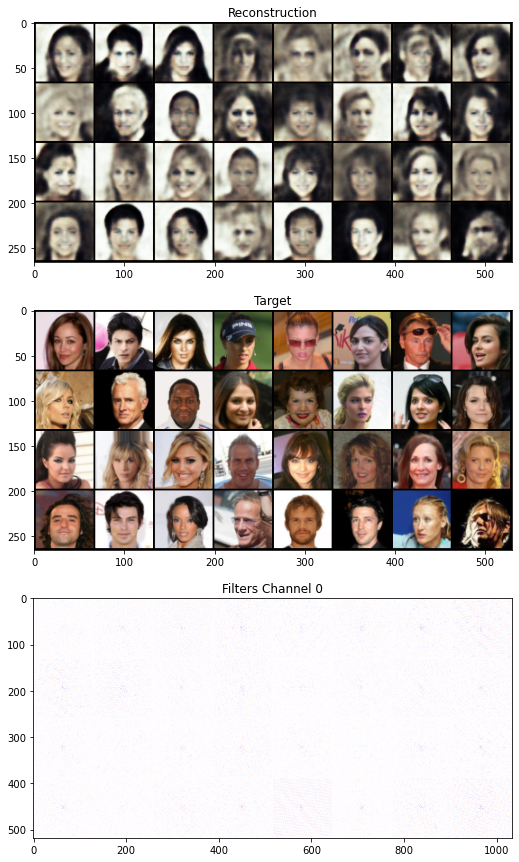

<Figure size 432x432 with 0 Axes>

 21% (21 of 100) |####                   | Elapsed Time: 0:33:30 ETA:   2:07:07


 {'epoch': 21, 'train_loss': 39.97031021118164, 'valid_loss': 42.74734115600586}
Filters range: [-0.10 , 1.00]


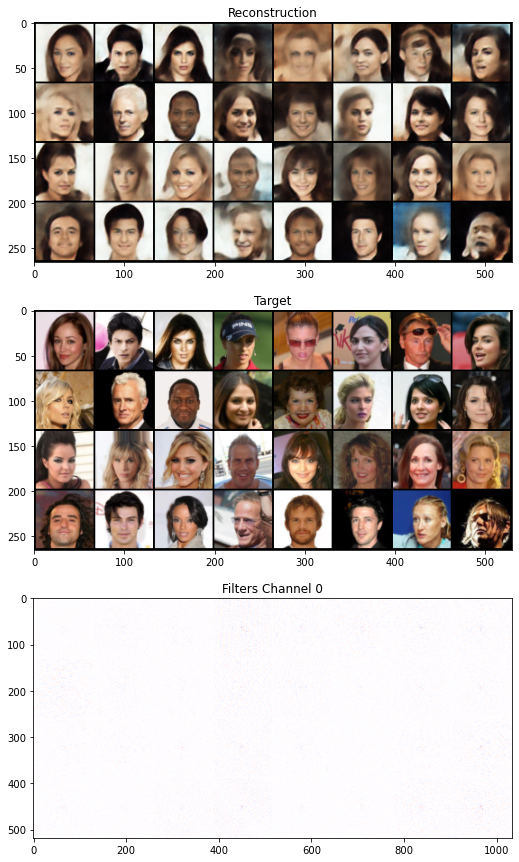

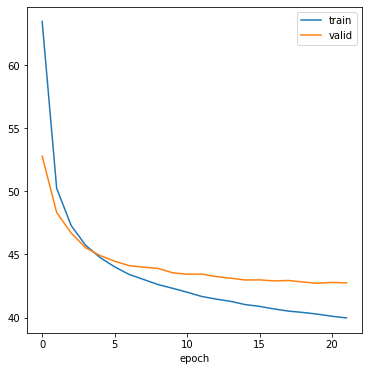

 42% (42 of 100) |#########              | Elapsed Time: 1:07:09 ETA:   1:32:21


 {'epoch': 42, 'train_loss': 38.2464599609375, 'valid_loss': 42.2559700012207}
Filters range: [-0.10 , 1.00]


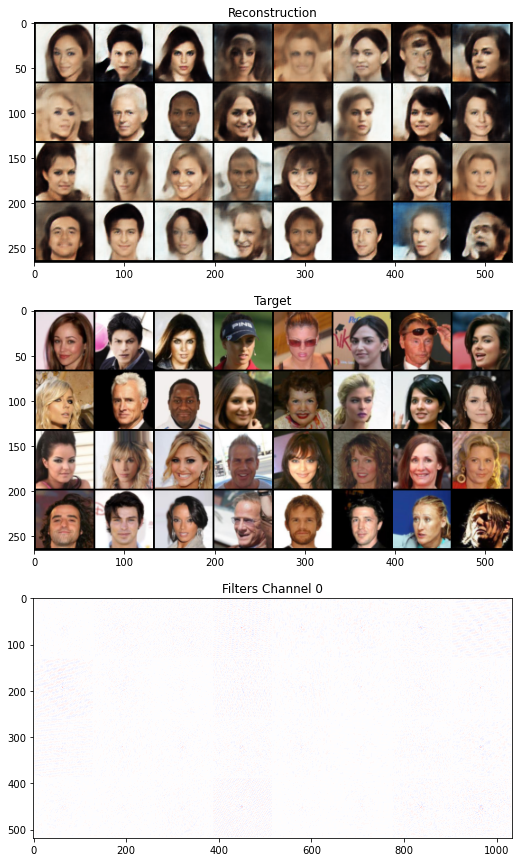

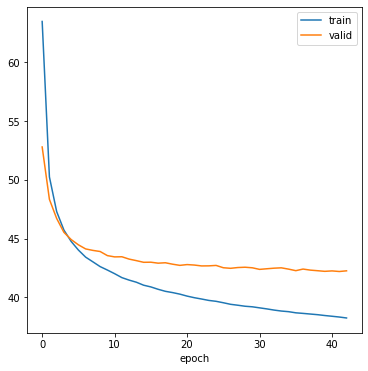

 63% (63 of 100) |##############         | Elapsed Time: 1:40:54 ETA:   0:58:47


 {'epoch': 63, 'train_loss': 37.36109161376953, 'valid_loss': 42.09805679321289}
Filters range: [-0.10 , 1.00]


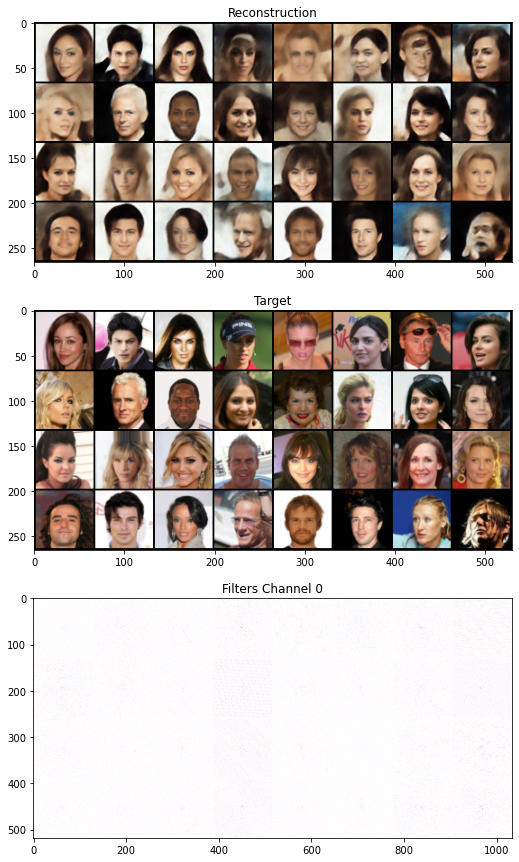

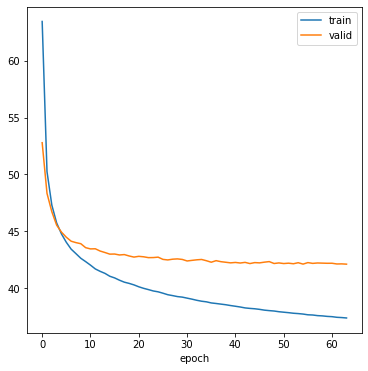

 84% (84 of 100) |###################    | Elapsed Time: 2:14:38 ETA:   0:25:52


 {'epoch': 84, 'train_loss': 36.85752868652344, 'valid_loss': 42.04983139038086}
Filters range: [-0.10 , 1.00]


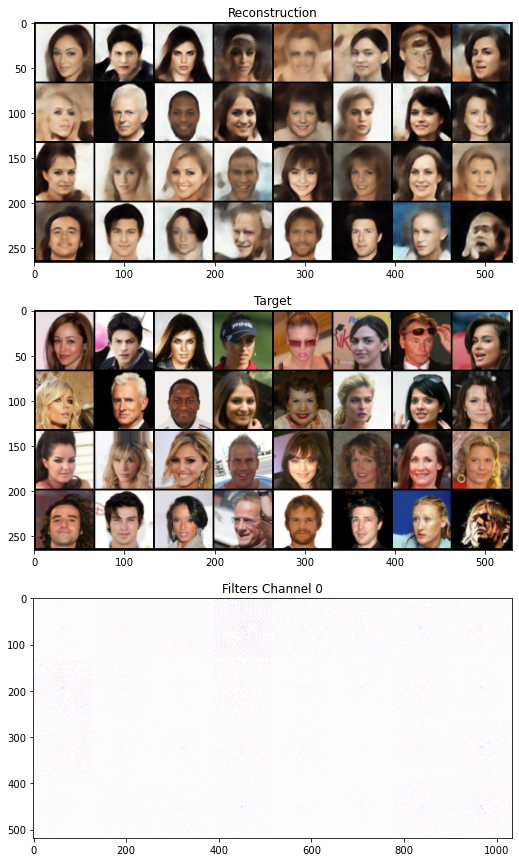

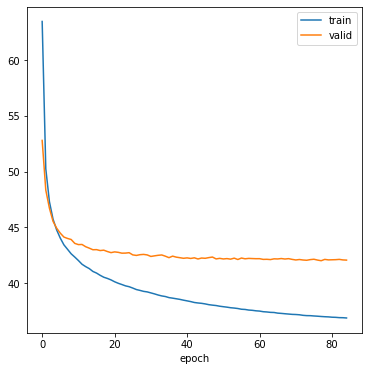

 99% (99 of 100) |###################### | Elapsed Time: 2:38:40 ETA:   0:01:36


 {'epoch': 99, 'train_loss': 36.72065353393555, 'valid_loss': 42.135650634765625}
Filters range: [-0.10 , 1.00]


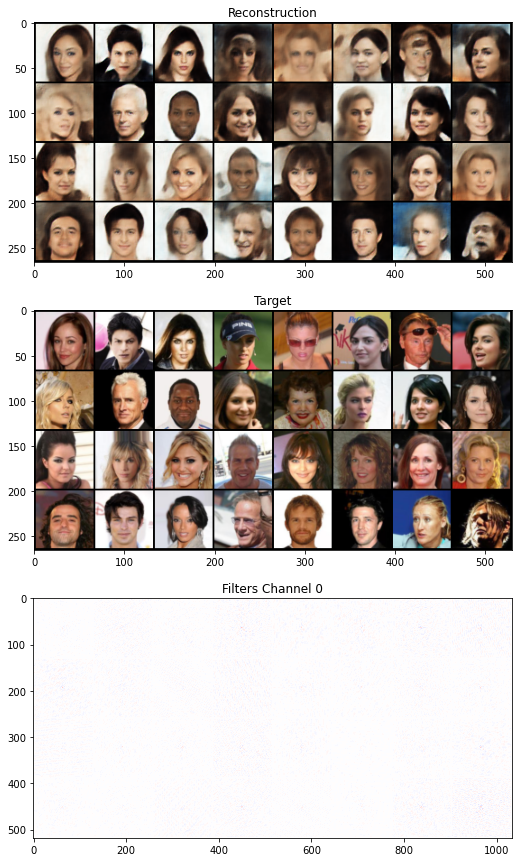

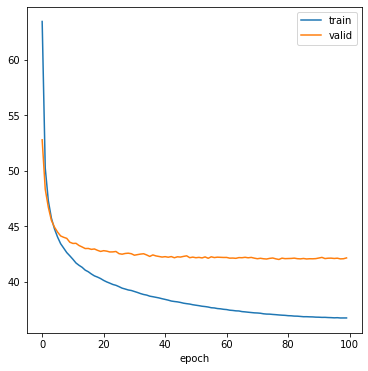

100% (100 of 100) |######################| Elapsed Time: 2:40:20 Time:  2:40:20


In [7]:
train_model(model, optimizer, train_loader, valid_loader, awloss, nepochs=nepochs,
            log_frequency=logf, device=model.device_ids[0], gradflow=False, save=True,
            scheduler=scheduler, fcmap="seismic", summary_app=summary_app)